## Parse ICD-10-CM code from Discharge summaries of MIMIC III Dataset using Amazon Comprehend Medical

This notebook walks through a demonstration of how Amazon Comprehend Medical can parse ICD-10 codes from the discharge summaries in the notesevents table. Since there are thousands of summaries in the MIMIC-III dataset, we use a subset of data. To identify a subset, we use discharge summaries of all admissions that had a diagnoses ICD-9 code of 428.21. This code represents “Acute systolic heart failure”

In [9]:
#This demonstation looks at medical conditions for patients that have been diagnosed with "Acute systolic heart failure".
#Change this to run for a different code. However, before you run the comprehend medical API, please get a cost estimate
#from https://aws.amazon.com/comprehend/pricing/ 
icd9code="42821"

In [10]:
import pandas as pd
import boto3
import botocore
import gzip
import shutil

The first step is to download the required files and unzip them.

In [3]:
#Download data
s3 = boto3.resource('s3')
s3.Bucket("mimic-iii-physionet").download_file('NOTEEVENTS.csv.gz', 'NOTEEVENTS.csv.gz')
s3.Bucket("mimic-iii-physionet").download_file('ADMISSIONS.csv.gz', 'ADMISSIONS.csv.gz')
s3.Bucket("mimic-iii-physionet").download_file('DIAGNOSES_ICD.csv.gz', 'DIAGNOSES_ICD.csv.gz')

#Unzip the files
with gzip.open('NOTEEVENTS.csv.gz', 'rb') as f_in:
    with open('NOTEEVENTS.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

with gzip.open('ADMISSIONS.csv.gz', 'rb') as f_in:
    with open('ADMISSIONS.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

with gzip.open('DIAGNOSES_ICD.csv.gz', 'rb') as f_in:
    with open('DIAGNOSES_ICD.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


The next step is to read the NoteEvents table into a DataFrame and also read the diagnoses table

In [8]:
#Read the noteevents table into a DataFrame
import csv
labels = ["ROW_ID","SUBJECT_ID","HADM_ID","CHARTDATE","CHARTTIME",
          "STORETIME","CATEGORY","DESCRIPTION","CGID","ISERROR","TEXT"]
with open("NOTEEVENTS.csv") as f:
    reader = csv.reader(f)
    csv_rows = list(reader)
events = pd.DataFrame.from_records(csv_rows,columns=labels)
#drop the header
events=events.drop(events.index[0])

#get all the admissions that have a particular diagnoses
HADM_IDS=set()
diagnoses_icd = pd.read_csv("DIAGNOSES_ICD.csv")
for row,diagnoses in diagnoses_icd.iterrows():
        # Change the ICD9 code  to run for a different diagnoses
        if (str(diagnoses['ICD9_CODE']).startswith(icd9code)):
            HADM_IDS.add(diagnoses['HADM_ID'])
events_heart = pd.DataFrame(columns=labels)
for row,event in events.iterrows():
    if ((event['HADM_ID'] != '') and (event['CATEGORY'] == 'Discharge summary')\
        and (int(event['HADM_ID']) in HADM_IDS)):
        events_heart=events_heart.append(event)
#Persist to a file to reuse data after notebook restart        
events_heart.to_pickle(f"{icd9code}.pkl")

In [29]:
#read from the persisted file if the code above has been run once.
#events_heart = pd.read_pickle(f"{icd9code}.pkl")

The next step is to use Comprehend Medical to parse the medical text. We use the infer_icd10_cm endpoint

In [ ]:
import boto3
client = boto3.client(service_name='comprehendmedical', region_name='ap-southeast-2')
lines = pd.DataFrame()
j = 0
for row,event in events_heart.iterrows():
    print(j)
    j=j+1
    a=event['TEXT']
    length=10000
    for i in range(0, len(a), length):
        icd10entities = client.infer_icd10_cm(Text=a[0+i:length+i])
        for entity in icd10entities['Entities']:
            if((entity['Category']=='MEDICAL_CONDITION') and (float(entity['Score']) > 0.8) ):
                for concept in entity['ICD10CMConcepts']:
                    if (concept['Score']>0.75):
                        lines = lines.append({'HADM_ID':event['HADM_ID'],
                                   'MEDICAL_CONDITION_NAME':concept['Description'],
                                   'ICDM_10C':concept['Code'],
                                   'SCORE':concept['Score']
                                    },ignore_index=True)

# The comprehend medical API charges per call and therefore we store the results in a file 
# to use them later if required.
lines.to_csv("heart_failures.csv")

The "heart_failures.csv" file has the medical conditions extracted using Comprehend Medical. While experimenting various models, do not rerun the medical comprehend code for the same dataset since it is charged per API call. Read the values from the csv file and then continue experimenting.

Merge with the admissions table to get the SUBJECT_ID

In [6]:
import pandas as pd
heart_failures_cause = pd.read_csv("heart_failures.csv")
# Load admissions
admissions = pd.read_csv("ADMISSIONS.csv",parse_dates=['ADMITTIME','DISCHTIME'])
HADM_ID_PATIENT_ID = {}
for row,admission in admissions.iterrows():
    HADM_ID_PATIENT_ID[admission['HADM_ID']] = admission['SUBJECT_ID']
heart_failures_sub = pd.DataFrame()
#Add SUBJECT_ID
for row,line in heart_failures_cause.iterrows():
    heart_failures_sub = heart_failures_sub.append({
                        'SUBJECT_ID':HADM_ID_PATIENT_ID[line['HADM_ID']],
                        'ICDM_10C':line['ICDM_10C'],
                        'MEDICAL_CONDITION_NAME' : line['MEDICAL_CONDITION_NAME']},ignore_index=True)

# get the patient ID
heart_failures_unq = heart_failures_sub.drop_duplicates(subset=['SUBJECT_ID','ICDM_10C'],keep=False)    

Its now time to look at top medical conditions.

Total Number of patients: 791


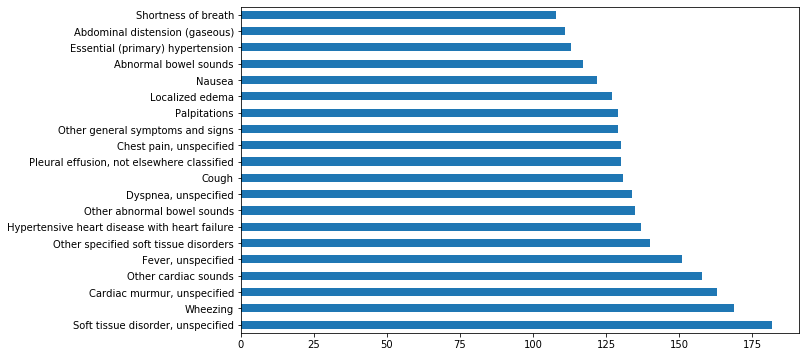

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=[10,6])
subject_ids = heart_failures_unq.iloc[:,0]
print("Total Number of patients: {}".format(subject_ids.value_counts().count()))
condition = heart_failures_unq.iloc[:,1]
condition.value_counts()[:20].plot(kind='barh')
plt.show()

In addition to the top medical conditions, we can also use the apriori algorithm to find out the medical conditions that occur together

In [8]:
#get the first 10 medical conditions
t = heart_failures_unq.loc[heart_failures_unq.MEDICAL_CONDITION_NAME.
                           isin(condition.value_counts().nlargest(10).index)]
# Keep only the required columns
y = t[['SUBJECT_ID','MEDICAL_CONDITION_NAME']]
# create a column called count and set it to 1. Kind of one hot encoding.
y['count'] = 1
# The work unspecified is removed for result brevity
y['MEDICAL_CONDITION_NAME']=y['MEDICAL_CONDITION_NAME'].str.replace("unspecified","")
# A bit of magical code to collapse the rows so that there is only one row per patient and 
# one hot encoded medical conditions
b = (y.groupby(['SUBJECT_ID','MEDICAL_CONDITION_NAME']))['count']\
.sum().unstack().reset_index().fillna(0)
# We can drop the Subject id.
b=b.drop(columns=['SUBJECT_ID'],axis=1)

In [ ]:
!pip install matplotlib
!pip install mlxtend

In [10]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
# run the apriori algorithm
frequent_itemsets = apriori(b, min_support=0.07, use_colnames=True)
# get the length of frequent itemsets
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
#keep only rows with two items. We do similar code for 3
frequent_itemsets_2=frequent_itemsets[ (frequent_itemsets['length'] == 2 )  ]
frequent_itemsets_2_sorted=frequent_itemsets_2.sort_values(by=['support'],ascending=False)

#Create html file for rows with two items.
html = frequent_itemsets_2_sorted.to_html()
text_file = open("frequent_itemsets_2_sorted.html", "w")
text_file.write(html)
text_file.close()

#Create html file for rows with two items.
frequent_itemsets_3=frequent_itemsets[ (frequent_itemsets['length'] == 3 )  ]
frequent_itemsets_3_sorted=frequent_itemsets_3.sort_values(by=['support'],ascending=False)
html = frequent_itemsets_3_sorted.to_html()
text_file = open("frequent_itemsets_3_sorted.html", "w")
text_file.write(html)
text_file.close()

Support indicates how frequently the medical conditions occur together. So the first condition occurs for about 23% of the transactions.

In [11]:
print(frequent_itemsets_2_sorted)

     support                                           itemsets  length
52  0.228070  (Soft tissue disorder, , Other specified soft ...       2
45  0.195175  (Other cardiac sounds, Other abnormal bowel so...       2
51  0.177632                   (Wheezing, Other cardiac sounds)       2
54  0.153509                 (Soft tissue disorder, , Wheezing)       2
48  0.142544            (Wheezing, Other abnormal bowel sounds)       2
50  0.140351     (Soft tissue disorder, , Other cardiac sounds)       2
15  0.138158           (Cardiac murmur, , Other cardiac sounds)       2
17  0.135965         (Cardiac murmur, , Soft tissue disorder, )       2
25  0.133772                    (Cough, Soft tissue disorder, )       2
38  0.127193                  (Fever, , Soft tissue disorder, )       2
53  0.122807  (Wheezing, Other specified soft tissue disorders)       2
47  0.122807  (Soft tissue disorder, , Other abnormal bowel ...       2
43  0.122807  (Soft tissue disorder, , Hypertensive heart di... 

In [12]:
print(frequent_itemsets_3_sorted)

     support                                           itemsets  length
61  0.109649  (Wheezing, Other cardiac sounds, Other abnorma...       3
63  0.096491  (Soft tissue disorder, , Wheezing, Other speci...       3
55  0.081140  (Cardiac murmur, , Soft tissue disorder, , Oth...       3
56  0.081140  (Cough, Soft tissue disorder, , Other specifie...       3
60  0.078947  (Soft tissue disorder, , Other cardiac sounds,...       3
59  0.076754  (Fever, , Soft tissue disorder, , Other specif...       3
58  0.072368  (Soft tissue disorder, , Other specified soft ...       3
62  0.072368  (Soft tissue disorder, , Other specified soft ...       3
57  0.070175        (Wheezing, Other cardiac sounds, Dyspnea, )       3


The purpose of this notebook was to explain how medical entities can be pa

End!